In [1]:
from reservoirUtils import *
%load_ext autoreload
%autoreload 2

## Schapiro et al. (2013)

(<Figure size 1200x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdc61480550>)

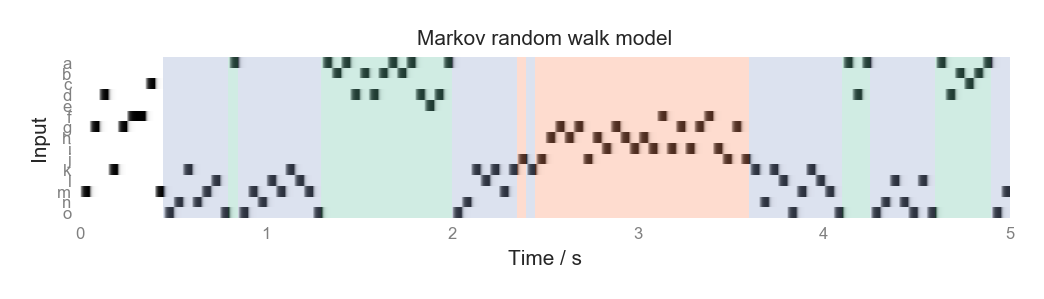

In [2]:
ips = defaultInputParams.copy()
ips['experiment'] = 'schapiro'
ips['syllables'] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o']
inputs = getInputs(ips,totalTime=2000)
inputsTest = getInputs(ips,totalTime=200)
plotInputs(inputsTest,title='Markov random walk model')

In [5]:
hyperparams = {'Ng' : 600, #no. neurons in each reservoir 
               'n' : 300, #no. reservoir neurons the output neuron is connected to 
               'p' : 0.5, #connection probability amongst recurrent units
               'tau' : 10, #neuron time constant, in ms 
               'dt' : 1, #simulation timestep in ms
               'g_GG' : 1.5, #RNN chaos parameters ( > 1 means chaos)
               'g_Gz' : 1, #feedback strength,
               'alpha' : 100, #learning rate
               'sigma' : 0.1,#amount of network noise
               'Nz' : 3, #no. of output neurons
               'Ni' : inputs['data'].shape[1]}

In [ ]:
reservoirPair = ReservoirPair(hyperparams,inputs)
reservoirPair.storeInputs(inputsTest,name='test')
reservoirPair.testPair(testName='pretraining',testData='test',Ntest=3,returnItems=['z','r'])
reservoirPair.trainPair(returnItems=['z','r'])
reservoirPair.testPair(testName='posttraining',testData='test',Ntest=3,returnItems=['z','r'])

In [67]:
pickleAndSave(reservoirPair,'schapiro')

In [3]:
reservoirPair = loadAndDepickle('schapiro')

(<Figure size 1200x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd92a671c18>)

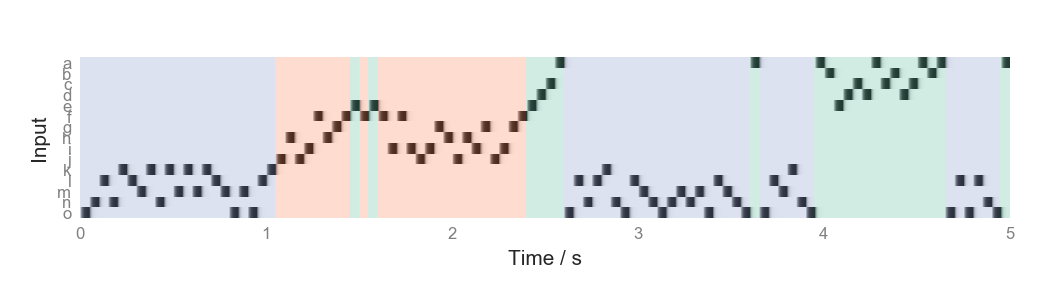

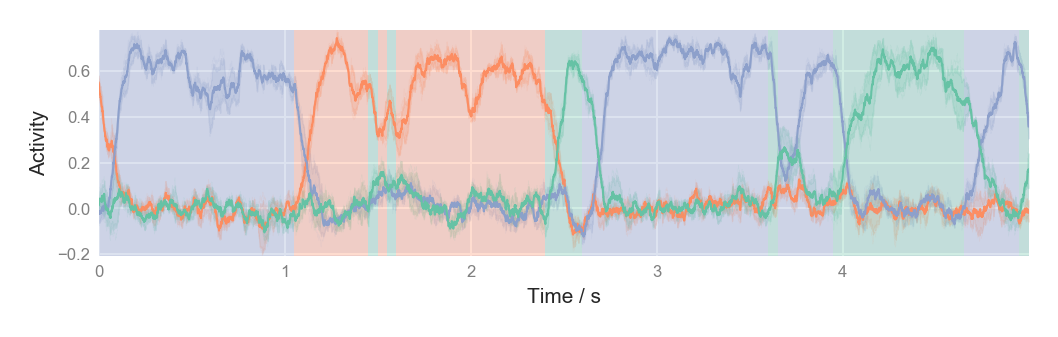

In [8]:
plotInputs(reservoirPair.inputDict['test'],tend=5,saveName='schapiroInputs')
plotTest(reservoirPair,testName='posttraining',testData='test',tend=5,colorOrders=[1,2,0],saveName="schapiroz")

In [5]:
# test low D dynamics of reservoir on chunks 
X = reservoirPair.hist['posttraining']['r'][:,:,0].T
X = X - np.mean(X,axis=0)
XX_T = np.matmul(X.T,X)
eigenvals, eigenvecs = np.linalg.eig(XX_T)
reducedX = np.matmul(X,eigenvecs[:,:2])

writer = anim.FFMpegWriter(fps=10,bitrate=4000) 
a = AnimatedScatter(reducedX,reservoirPair.inputDict['test'],fps=10,length=50)
a.ani.save('./figures/schapiro.mp4', writer=writer,dpi=250)

In [6]:
Video("./figures/schapiro.mp4")

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o']
(600, 100000, 3)


Text(0, 0.5, 'PC2, 18.4% V.E.')

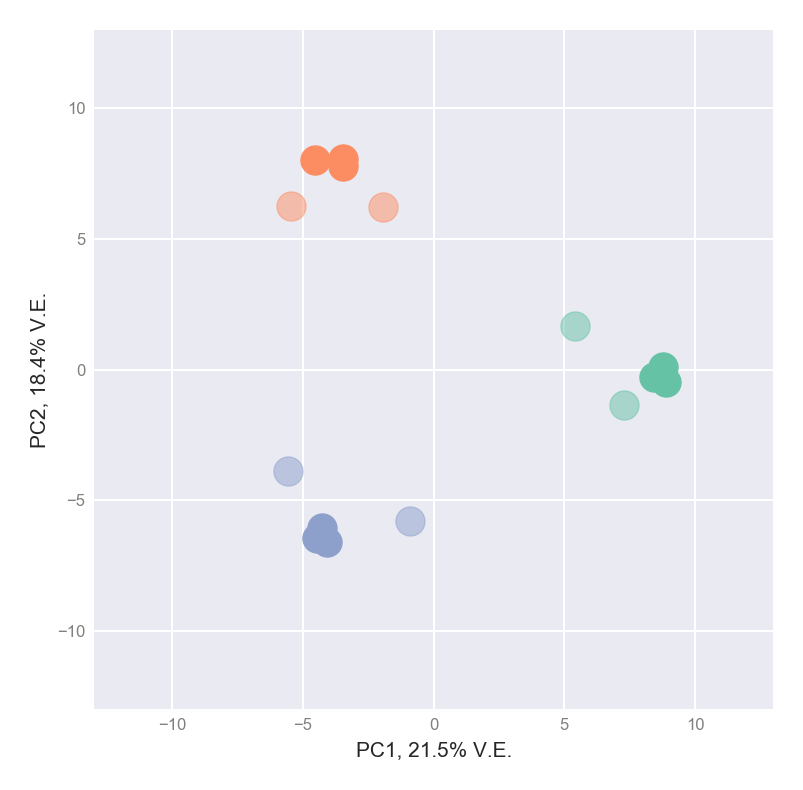

In [11]:
data = reservoirPair.hist['posttraining']['r']
inputs = reservoirPair.inputDict['test']['data']
syllables = reservoirPair.inputDict['test']['syllables']
print(syllables)
print(data.shape)
avResults = {}
for letter in syllables:
    avResults[letter] = {}
    avResults[letter]['n'] = 0
    avResults[letter]['av'] = np.zeros(data.shape[0])


for n_trial in range(data.shape[2]):
    for i in range(data[:,:,n_trial].shape[1]):
        letterId = np.argmax(inputs[i,:])
        letter = syllables[letterId]
        avResults[letter]['n'] += 1
        n = avResults[letter]['n']
        x = avResults[letter]['av']
        avResults[letter]['av'] = (1 - 1/n)*x + (1/n)*data[:,i,n_trial]

fig, ax = plt.subplots(figsize=(3,3))
for syllable in syllables:
    reducedSyllableData = np.matmul(avResults[syllable]['av'],eigenvecs[:,:2])
    if syllable in ['a','b','c','d','e']:
        c='C0'
    elif syllable in ['f','g','h','i','j']:
        c='C1'
    elif syllable in ['k','l','m','n','o']:
        c='C2'
    alpha=1
    if syllable in ['a','e','f','j','k','o']:
        alpha=0.5
    ax.scatter(reducedSyllableData[0],reducedSyllableData[1],c=c,alpha=alpha)
ax.axis([-13, 13, -13, 13])
ax.set_aspect('equal')
ax.set_xlabel('PC1, %.1f%% V.E.' %(100*eigenvals[0]/np.sum(eigenvals)))
ax.set_ylabel('PC2, %.1f%% V.E.' %(100*eigenvals[1]/np.sum(eigenvals)))
    
